## Q2.1 MLP Multi-Class Classifier

Importing libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import pickle
import re
import seaborn as sns
import warnings
import os
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import confusion_matrix, classification_report
from PIL import Image
warnings.filterwarnings('ignore')
from sklearn.model_selection import KFold
import torch
from torch.utils.data import Dataset
from torchvision import transforms


## 2.1.2 Model Development from scratch

In [ ]:
class ActivationFunction:
    class ReLU:
        def forward(self, x):
            return np.maximum(0, x)
        def derivative(self, x):
            return np.where(x > 0, 1.0, 0.0)
    class Tanh:
        def forward(self, x):
            return np.tanh(x)
        def derivative(self, x):
            return 1 - np.square(np.tanh(x))
    class Sigmoid:
        def forward(self, x):
            return 1 / (1 + np.exp(-x))
        def derivative(self, x):
            s = self.forward(x)
            return s * (1 - s)
    class Softmax:
        def forward(self, x):
            exp_x = np.exp(x - np.max(x, axis=0, keepdims=True))  # Numerical stability
            return exp_x / np.sum(exp_x, axis=0, keepdims=True)

class Layer:
    def __init__(self, input_size, output_size, activation):
        self.activation = activation
        self.weights = np.random.randn(output_size, input_size) * np.sqrt(2 / input_size)
        self.biases = np.zeros((output_size, 1))
        self.dw = None
        self.db = None
    
    def forward(self, x):
        self.a_prev = x
        self.z = np.dot(self.weights, x) + self.biases
        self.a = self.activation.forward(self.z)
        return self.a
    
    def backward(self, grad):
        delta = grad * self.activation.derivative(self.z)
        self.dw = np.dot(delta, self.a_prev.T)
        self.db = np.sum(delta, axis=1, keepdims=True)
        return np.dot(self.weights.T, delta)
    
class LossFunction:
    class CategoricalCrossEntropy:
        def compute(self, y_true, y_pred):
            y_pred = np.clip(y_pred, 1e-15, 1 - 1e-15) 
            return -np.sum(y_true * np.log(y_pred)) / y_true.shape[1]
        def derivative(self, y_true, y_pred):
            return y_pred - y_true 

class Optimizer:
    class SGD:
        def __init__(self, learning_rate):
            self.learning_rate = learning_rate
        
        def update(self, layers):
            for layer in layers:
                layer.weights -= self.learning_rate * layer.dw
                layer.biases -= self.learning_rate * layer.db
                
    class BatchGradientDescent:
        def __init__(self, learning_rate):
            self.learning_rate = learning_rate
        
        def update(self, layers):
            for layer in layers:
                layer.weights -= self.learning_rate * layer.dw
                layer.biases -= self.learning_rate * layer.db
    
    class MiniBatchGradientDescent:
        def __init__(self, learning_rate, batch_size):
            self.learning_rate = learning_rate
            self.batch_size = batch_size
        
        def update(self, layers):
            for layer in layers:
                layer.weights -= self.learning_rate * layer.dw
                layer.biases -= self.learning_rate * layer.db

class DataLoader:
    def __init__(self, X, y, batch_size):
        self.X = np.array(X)
        self.y = np.array(y)
        self.batch_size = batch_size
        self.n_samples = self.X.shape[0]
    
    def get_batch(self):
        indices = np.arange(self.n_samples)
        np.random.shuffle(indices)
        for i in range(0, self.n_samples, self.batch_size):
            batch_indices = indices[i:i+self.batch_size]
            yield self.X[batch_indices], self.y[batch_indices]

class MLPClassifier:
    def __init__(self, layer_sizes, hidden_activation,optimizer_type, learning_rate=0.01, batch_size=32):
        self.layers = []
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        
        activation_map = {
            'sigmoid': ActivationFunction.Sigmoid(),
            'tanh': ActivationFunction.Tanh(),
            'relu': ActivationFunction.ReLU(),
            'softmax': ActivationFunction.Softmax()
        }
        
        hidden_act = activation_map[hidden_activation]
        
        for i in range(len(layer_sizes)-2):
            self.layers.append(Layer(layer_sizes[i], layer_sizes[i+1], hidden_act))
        
        self.layers.append(Layer(layer_sizes[-2], layer_sizes[-1], ActivationFunction.Softmax()))
        
        if optimizer_type == 'sgd':
            self.optimizer = Optimizer.SGD(learning_rate)
            self.batch_size = 1
        elif optimizer_type == 'mini_batch_gradient_descent':
            self.optimizer = Optimizer.MiniBatchGradientDescent(learning_rate, batch_size)
            self.use_full_batch = False
        elif optimizer_type == 'batch_gradient_descent':
            self.optimizer = Optimizer.BatchGradientDescent(learning_rate)
            self.use_full_batch = True        
        self.loss_history = []
        self.accuracy_history = []
    
    def forward(self, x):
        self.a_prev = x
        for layer in self.layers:
            self.a_prev = layer.forward(self.a_prev)
        return self.a_prev
    
    def backward(self, y_true, y_pred):
        grad = LossFunction.CategoricalCrossEntropy().derivative(y_true, y_pred)
        for layer in reversed(self.layers):
            grad = layer.backward(grad)
    
    def calculate_accuracy(self, y_true, y_pred):
        y_pred_classes = np.argmax(y_pred, axis=0)
        y_true_classes = np.argmax(y_true, axis=0)
        return np.mean(y_pred_classes == y_true_classes)
    
    def train(self, X_train, y_train, X_val=None, y_val=None, epochs=100):
        data_loader = DataLoader(X_train, y_train, self.batch_size)
        
        for epoch in range(epochs):
            epoch_losses = []
            epoch_accuracies = []
            
            for X_batch, y_batch in data_loader.get_batch():
                y_pred = self.forward(X_batch.T)
                
                loss = LossFunction.CategoricalCrossEntropy().compute(y_batch.T, y_pred)
                accuracy = self.calculate_accuracy(y_batch.T, y_pred)
                
                epoch_losses.append(loss)
                epoch_accuracies.append(accuracy)
                
                self.backward(y_batch.T, y_pred)
                self.optimizer.update(self.layers)
            
            avg_loss = np.mean(epoch_losses)
            avg_accuracy = np.mean(epoch_accuracies)
            self.loss_history.append(avg_loss)
            self.accuracy_history.append(avg_accuracy)
            
            if (epoch + 1) % 10 == 0:
                print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {avg_loss:.4f}, Train Acc: {avg_accuracy:.4f}")
    
    def predict(self, X):
        return self.forward(np.array(X).T).T
    
    def predict_classes(self, X):
        probs = self.predict(X)
        return np.argmax(probs, axis=1)
    
    def evaluate(self, X, y):
        # return accuracy, loss and predictions
        y_pred = self.predict(X)
        loss = LossFunction.CategoricalCrossEntropy().compute(y.T, y_pred)
        accuracy = self.calculate_accuracy(y.T, y_pred)
        return {
            'accuracy': accuracy,
            'loss': loss,
            'predictions': y_pred
        }

In [ ]:
def convert_to_one_hot(y_raw, output_dim):
    y_one_hot = torch.zeros(len(y_raw), output_dim, device=y_raw.device)
    y_one_hot.scatter_(1, y_raw.unsqueeze(1), 1)
    return y_one_hot

def cross_validate(X_data, y_data, k, input_dimension, output_dimension, hidden_layers, activation, 
                   optimizer, learning_rate, epochs, batch_size):
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    accuracy_vals, loss_graphs = [], []
    
    for fold, (train_idx, val_idx) in enumerate(kf.split(X_data)):
        print(f"Fold {fold+1}/{k}")
        
        X_train, X_val = X_data[train_idx], X_data[val_idx]
        y_train, y_val = y_data[train_idx], y_data[val_idx]
        
        model = MLPClassifier(
            input_dim=input_dimension,
            output_dim=output_dimension,
            hidden_layers=hidden_layers,
            activation=activation,
            optimizer=optimizer,
            learning_rate=learning_rate,
            epochs=epochs,
            batch_size=batch_size
        )
        loss_history = model.train(X_train, y_train)
        loss_graphs.append(loss_history)
        results = model.evaluate(X_val, y_val)
        accuracy_vals.append(results['accuracy'])
        print(f"Fold {fold+1} accuracy: {results['accuracy']:.4f}, loss: {results['loss']:.4f}")
    mean_accuracy = np.mean(accuracy_vals)
    std_accuracy = np.std(accuracy_vals)
    print(f"Mean accuracy: {mean_accuracy:.4f} ± {std_accuracy:.4f}")
    return accuracy_vals, mean_accuracy, std_accuracy, loss_graphs

def plot_results(accuracies, loss_curves):
    plt.figure(figsize=(15, 5))
    plt.xlabel('Fold')
    plt.ylabel('Accuracy')
    plt.subplot(1, 2, 1)
    plt.bar(range(1, len(accuracies) + 1), accuracies)
    plt.axhline(y=np.mean(accuracies), color='r', linestyle='-', label=f'Mean: {np.mean(accuracies):.4f}')
    plt.title('Accuracy per Fold')
    plt.xticks(range(1, len(accuracies) + 1))
    plt.legend()
    
    plt.subplot(1, 2, 2)
    avg_loss = np.mean([np.array(curve) for curve in loss_curves], axis=0)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(avg_loss)
    plt.title('Average Training Loss')
    
    plt.tight_layout()
    plt.show()


def plot_top_outputs(top_outputs, n=5):

    plt.figure(figsize=(12, 8))
    models = [f"{x['optimizer']}_{x['activation']}_{x['hidden_layers']}" for x in top_outputs[:n]]
    mean_accs = [x['mean_accuracy'] for x in top_outputs[:n]]
    std_accs = [x['std_accuracy'] for x in top_outputs[:n]]
    plt.barh(range(len(models)), mean_accs, xerr=std_accs, alpha=0.7)
    plt.yticks(range(len(models)), models)
    plt.title('Top Performing Models')
    plt.xlabel('Validation Accuracy')
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    for i, v in enumerate(mean_accs):
        plt.text(v + 0.01, i, f"{v:.4f} ± {std_accs[i]:.4f}", va='center')
    plt.tight_layout()
    plt.show()

def hyperparam_search(X_data, y_data):
    learning_rates = [0.01, 0.001]
    batch_sizes = [32, 64, 128]
    activations = ['sigmoid', 'tanh', 'relu']
    optimizers = ['sgd', 'batch_gradient_descent','mini_batch_gradient_descent']
    hidden_layers_list = [[128], [64, 32], [128, 64, 32]]
    
    input_dimension = X_data.shape[1]
    output_dimension = len(torch.unique(y_data))
    k_folds = 5
    epochs = 20
    results = []
    
    experiments = []
    
    for hidden_layers in hidden_layers_list:
        for activation in activations:
            for optimizer in optimizers:
                for lr in learning_rates:
                    for batch_size in batch_sizes:
                        experiments.append({
                            'hidden_layers': hidden_layers,
                            'activation': activation,
                            'optimizer': optimizer,
                            'learning_rate': lr,
                            'batch_size': batch_size
                        })
    
    for i, exp in enumerate(experiments):
        print(f"\n{'='*80}")
        print(f"Running experiment {i+1}/{len(experiments)}:")
        for key, value in exp.items():
            print(f"{key}: {value}")
        print(f"{'='*80}\n")
        
        accuracies, mean_acc, std_acc, loss_curves = cross_validate(
            X_data=X_data,
            y_data=y_data,
            k=k_folds,
            input_dimension=input_dimension,
            learning_rate=exp['learning_rate'],
            epochs=epochs,
            batch_size=exp['batch_size']
            activation=exp['activation'],
            optimizer=exp['optimizer'],
            output_dimension=output_dimension,
            hidden_layers=exp['hidden_layers'],
        )
        
        plt.figure(figsize=(15, 5))
        title = f"{exp['activation'].capitalize()}, {exp['optimizer']}, lr={exp['learning_rate']}, layers={exp['hidden_layers']}"
        plt.suptitle(title)
        plot_results(accuracies, loss_curves) 
        results.append({
            **exp,
            'mean_accuracy': mean_acc,
            'std_accuracy': std_acc,
            'accuracies': accuracies,
            'loss_curves': loss_curves
        })
    
    results.sort(key=lambda x: x['mean_accuracy'], reverse=True)
    
    print("\n\n" + "="*120)
    print("SUMMARY OF RESULTS (ORDERED BY MEAN ACCURACY)")
    print("="*120)
    
    headers = ["Rank", "Hidden Layers", "Activation", "Optimizer", "Learning Rate","Batch Size", "Mean Accuracy", "Std Dev"]
    print(f"{headers[0]:<6}{headers[1]:<20}{headers[2]:<10}{headers[3]:<15}{headers[4]:<15}{headers[5]:<15}{headers[6]:<15}{headers[7]:<10}")
    print("-"*120)
    
    for i, r in enumerate(results):
        print(f"{i+1:<6}{str(r['hidden_layers']):<20}{r['activation']:<10}"
              f"{r['optimizer']:<15}{r['learning_rate']:<15}{r['batch_size']:<15}"
              f"{r['mean_accuracy']:.4f}±{r['std_accuracy']:.4f}")
    
    plot_top_outputs(results[:5])
    return results


Running experiment with:
Hidden Layers: [64, 32]
Activation: sigmoid
Optimizer: sgd
Learning Rate: 0.01
Batch Size: 1

Using device: cuda
Processing fold 1


Loading test fold-1: 100%|██████████| 16992/16992 [00:02<00:00, 7119.82it/s]


Epoch 10/10, Loss: 1.4421
Fold 1 Accuracy: 0.6317 Avg Train Loss: 1.9690

Processing fold 2


Loading test fold-2: 100%|██████████| 16945/16945 [00:02<00:00, 6699.79it/s]


Epoch 10/10, Loss: 1.4469
Fold 2 Accuracy: 0.6269 Avg Train Loss: 1.9744

Processing fold 3


Loading test fold-3: 100%|██████████| 16913/16913 [00:02<00:00, 7479.41it/s]


Epoch 10/10, Loss: 1.4489
Fold 3 Accuracy: 0.6296 Avg Train Loss: 1.9873

Processing fold 4


Loading test fold-4: 100%|██████████| 16875/16875 [00:02<00:00, 7482.55it/s]


Epoch 10/10, Loss: 1.4282
Fold 4 Accuracy: 0.6274 Avg Train Loss: 1.9587

Processing fold 5


Loading test fold-5: 100%|██████████| 16838/16838 [00:02<00:00, 7388.38it/s]


Epoch 10/10, Loss: 1.4330
Fold 5 Accuracy: 0.6118 Avg Train Loss: 1.9677

Processing fold 6


Loading test fold-6: 100%|██████████| 16810/16810 [00:02<00:00, 7479.72it/s]


Epoch 10/10, Loss: 1.4175
Fold 6 Accuracy: 0.6267 Avg Train Loss: 1.9786

Processing fold 7


Loading test fold-7: 100%|██████████| 16769/16769 [00:02<00:00, 7370.35it/s]


Epoch 10/10, Loss: 1.4640
Fold 7 Accuracy: 0.6152 Avg Train Loss: 1.9919

Processing fold 8


Loading test fold-8: 100%|██████████| 16732/16732 [00:02<00:00, 7101.99it/s]


Epoch 10/10, Loss: 1.4219
Fold 8 Accuracy: 0.6247 Avg Train Loss: 1.9732

Processing fold 9


Loading test fold-9: 100%|██████████| 16698/16698 [00:02<00:00, 7089.23it/s]


Epoch 10/10, Loss: 1.4347
Fold 9 Accuracy: 0.6274 Avg Train Loss: 1.9738

Processing fold 10


Loading test fold-10: 100%|██████████| 16661/16661 [00:02<00:00, 7172.88it/s]


Epoch 10/10, Loss: 1.4381
Fold 10 Accuracy: 0.6168 Avg Train Loss: 1.9905



<Figure size 1500x500 with 0 Axes>

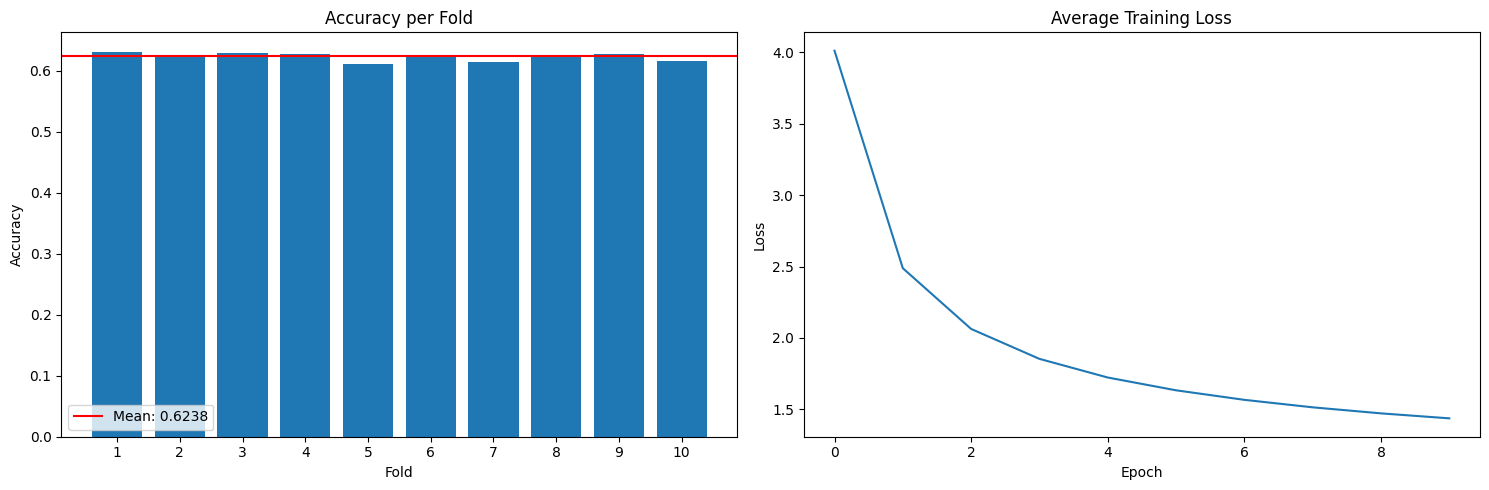


Running experiment with:
Hidden Layers: [64, 32]
Activation: tanh
Optimizer: sgd
Learning Rate: 0.01
Batch Size: 1

Using device: cuda
Processing fold 1


Loading test fold-1: 100%|██████████| 16992/16992 [00:02<00:00, 6951.48it/s]


Epoch 10/10, Loss: 2.1211
Fold 1 Accuracy: 0.5004 Avg Train Loss: 2.4456

Processing fold 2


Loading test fold-2: 100%|██████████| 16945/16945 [00:02<00:00, 7171.88it/s]


Epoch 10/10, Loss: 2.2295
Fold 2 Accuracy: 0.4707 Avg Train Loss: 2.4800

Processing fold 3


Loading test fold-3: 100%|██████████| 16913/16913 [00:02<00:00, 7124.72it/s]


Epoch 10/10, Loss: 2.1673
Fold 3 Accuracy: 0.4724 Avg Train Loss: 2.4900

Processing fold 4


Loading test fold-4: 100%|██████████| 16875/16875 [00:02<00:00, 6926.06it/s]


Epoch 10/10, Loss: 2.1589
Fold 4 Accuracy: 0.4930 Avg Train Loss: 2.4692

Processing fold 5


Loading test fold-5: 100%|██████████| 16838/16838 [00:02<00:00, 7377.62it/s]


Epoch 10/10, Loss: 2.1895
Fold 5 Accuracy: 0.4730 Avg Train Loss: 2.4759

Processing fold 6


Loading test fold-6: 100%|██████████| 16810/16810 [00:02<00:00, 7373.60it/s]


Epoch 10/10, Loss: 2.1776
Fold 6 Accuracy: 0.4781 Avg Train Loss: 2.5109

Processing fold 7


Loading test fold-7: 100%|██████████| 16769/16769 [00:02<00:00, 7179.48it/s]


Epoch 10/10, Loss: 2.2352
Fold 7 Accuracy: 0.4476 Avg Train Loss: 2.5206

Processing fold 8


Loading test fold-8: 100%|██████████| 16732/16732 [00:02<00:00, 7467.78it/s]


Epoch 10/10, Loss: 2.1441
Fold 8 Accuracy: 0.4770 Avg Train Loss: 2.4812

Processing fold 9


Loading test fold-9: 100%|██████████| 16698/16698 [00:02<00:00, 7539.64it/s]


Epoch 10/10, Loss: 2.0839
Fold 9 Accuracy: 0.5076 Avg Train Loss: 2.4419

Processing fold 10


Loading test fold-10: 100%|██████████| 16661/16661 [00:02<00:00, 7099.76it/s]


Epoch 10/10, Loss: 2.1397
Fold 10 Accuracy: 0.4834 Avg Train Loss: 2.4539



<Figure size 1500x500 with 0 Axes>

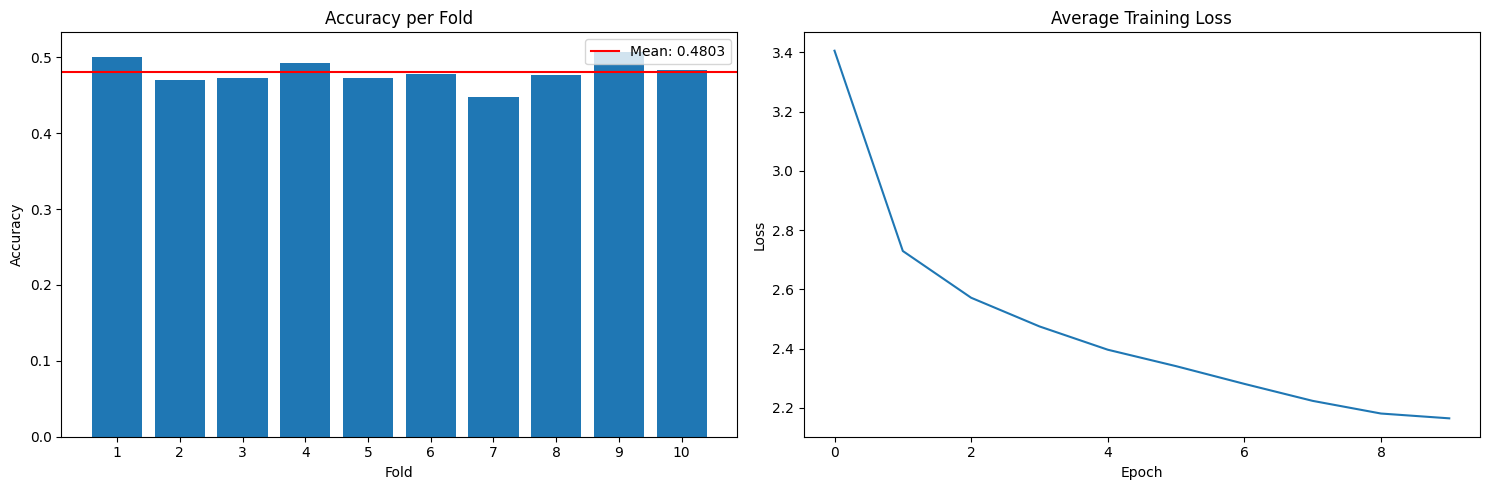


Running experiment with:
Hidden Layers: [64, 32]
Activation: relu
Optimizer: sgd
Learning Rate: 0.01
Batch Size: 1

Using device: cuda
Processing fold 1


Loading test fold-1: 100%|██████████| 16992/16992 [00:02<00:00, 7199.06it/s]


Epoch 10/10, Loss: 3.0405
Fold 1 Accuracy: 0.2947 Avg Train Loss: 3.4573

Processing fold 2


Loading test fold-2: 100%|██████████| 16945/16945 [00:02<00:00, 7225.23it/s]


Epoch 10/10, Loss: 3.3014
Fold 2 Accuracy: 0.2754 Avg Train Loss: 3.5963

Processing fold 3


Loading test fold-3: 100%|██████████| 16913/16913 [00:02<00:00, 7624.89it/s]


Epoch 10/10, Loss: 3.2825
Fold 3 Accuracy: 0.2639 Avg Train Loss: 3.7081

Processing fold 4


Loading test fold-4: 100%|██████████| 16875/16875 [00:02<00:00, 7594.52it/s]


Epoch 10/10, Loss: 3.2783
Fold 4 Accuracy: 0.2926 Avg Train Loss: 3.5531

Processing fold 5


Loading test fold-5: 100%|██████████| 16838/16838 [00:02<00:00, 7592.39it/s]


Epoch 10/10, Loss: 3.1156
Fold 5 Accuracy: 0.3315 Avg Train Loss: 3.5515

Processing fold 6


Loading test fold-6: 100%|██████████| 16810/16810 [00:02<00:00, 7235.21it/s]


Epoch 10/10, Loss: 3.1905
Fold 6 Accuracy: 0.3181 Avg Train Loss: 3.3983

Processing fold 7


Loading test fold-7: 100%|██████████| 16769/16769 [00:02<00:00, 7589.68it/s]


Epoch 10/10, Loss: 3.3909
Fold 7 Accuracy: 0.3017 Avg Train Loss: 3.6047

Processing fold 8


Loading test fold-8: 100%|██████████| 16732/16732 [00:02<00:00, 7538.19it/s]


Epoch 10/10, Loss: 3.3912
Fold 8 Accuracy: 0.2153 Avg Train Loss: 3.6562

Processing fold 9


Loading test fold-9: 100%|██████████| 16698/16698 [00:02<00:00, 7627.23it/s]


Epoch 10/10, Loss: 3.0942
Fold 9 Accuracy: 0.3490 Avg Train Loss: 3.4895

Processing fold 10


Loading test fold-10: 100%|██████████| 16661/16661 [00:02<00:00, 7217.24it/s]


Epoch 10/10, Loss: 3.2967
Fold 10 Accuracy: 0.3280 Avg Train Loss: 3.5358



<Figure size 1500x500 with 0 Axes>

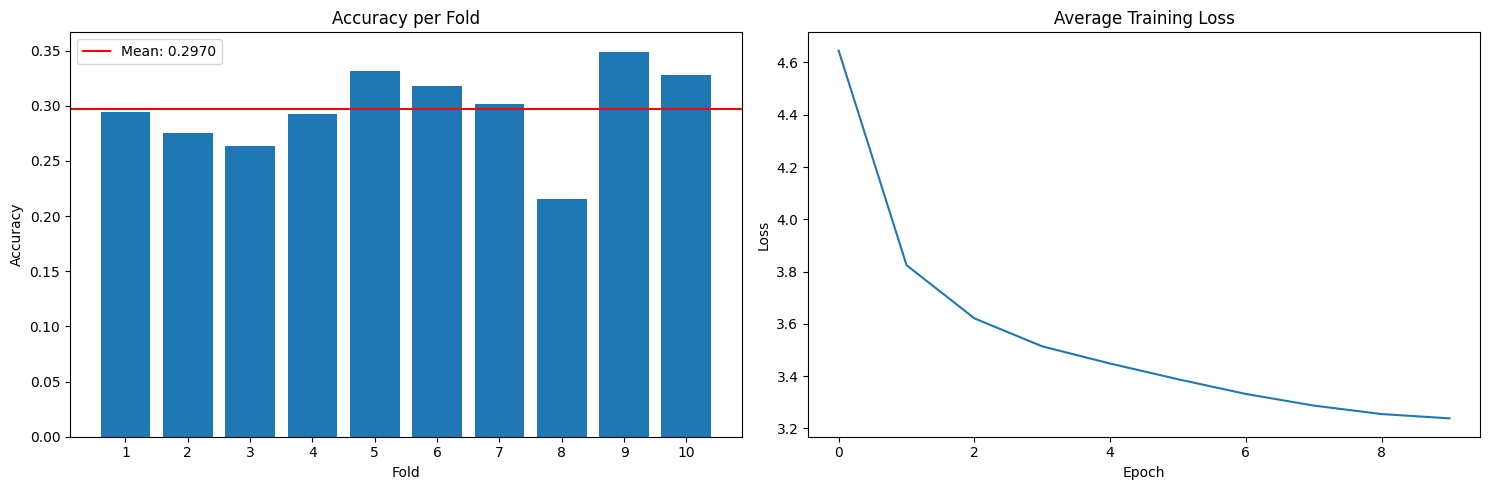


Running experiment with:
Hidden Layers: [64, 32]
Activation: sigmoid
Optimizer: batch_gradient_descent
Learning Rate: 0.01
Batch Size: 32

Using device: cuda
Processing fold 1


Loading test fold-1: 100%|██████████| 16992/16992 [00:02<00:00, 7157.96it/s]


Epoch 10/10, Loss: 6.0740
Fold 1 Accuracy: 0.0020 Avg Train Loss: 6.0778

Processing fold 2


Loading test fold-2: 100%|██████████| 16945/16945 [00:02<00:00, 7538.74it/s]


Epoch 10/10, Loss: 6.0479
Fold 2 Accuracy: 0.0008 Avg Train Loss: 6.0519

Processing fold 3


Loading test fold-3: 100%|██████████| 16913/16913 [00:02<00:00, 7669.36it/s]


Epoch 10/10, Loss: 6.0455
Fold 3 Accuracy: 0.0015 Avg Train Loss: 6.0491

Processing fold 4


Loading test fold-4: 100%|██████████| 16875/16875 [00:02<00:00, 7699.95it/s]


Epoch 10/10, Loss: 6.0511
Fold 4 Accuracy: 0.0008 Avg Train Loss: 6.0544

Processing fold 5


Loading test fold-5: 100%|██████████| 16838/16838 [00:02<00:00, 7660.51it/s]


Epoch 10/10, Loss: 6.0427
Fold 5 Accuracy: 0.0026 Avg Train Loss: 6.0463

Processing fold 6


Loading test fold-6: 100%|██████████| 16810/16810 [00:02<00:00, 7588.51it/s]


Epoch 10/10, Loss: 6.0466
Fold 6 Accuracy: 0.0009 Avg Train Loss: 6.0505

Processing fold 7


Loading test fold-7: 100%|██████████| 16769/16769 [00:02<00:00, 7630.27it/s]


Epoch 10/10, Loss: 6.0619
Fold 7 Accuracy: 0.0060 Avg Train Loss: 6.0656

Processing fold 8


Loading test fold-8: 100%|██████████| 16732/16732 [00:02<00:00, 7629.28it/s]


Epoch 10/10, Loss: 6.0182
Fold 8 Accuracy: 0.0023 Avg Train Loss: 6.0209

Processing fold 9


Loading test fold-9: 100%|██████████| 16698/16698 [00:02<00:00, 7700.97it/s]


Epoch 10/10, Loss: 6.0374
Fold 9 Accuracy: 0.0006 Avg Train Loss: 6.0411

Processing fold 10


Loading test fold-10: 100%|██████████| 16661/16661 [00:02<00:00, 7613.06it/s]


Epoch 10/10, Loss: 6.0561
Fold 10 Accuracy: 0.0013 Avg Train Loss: 6.0598



<Figure size 1500x500 with 0 Axes>

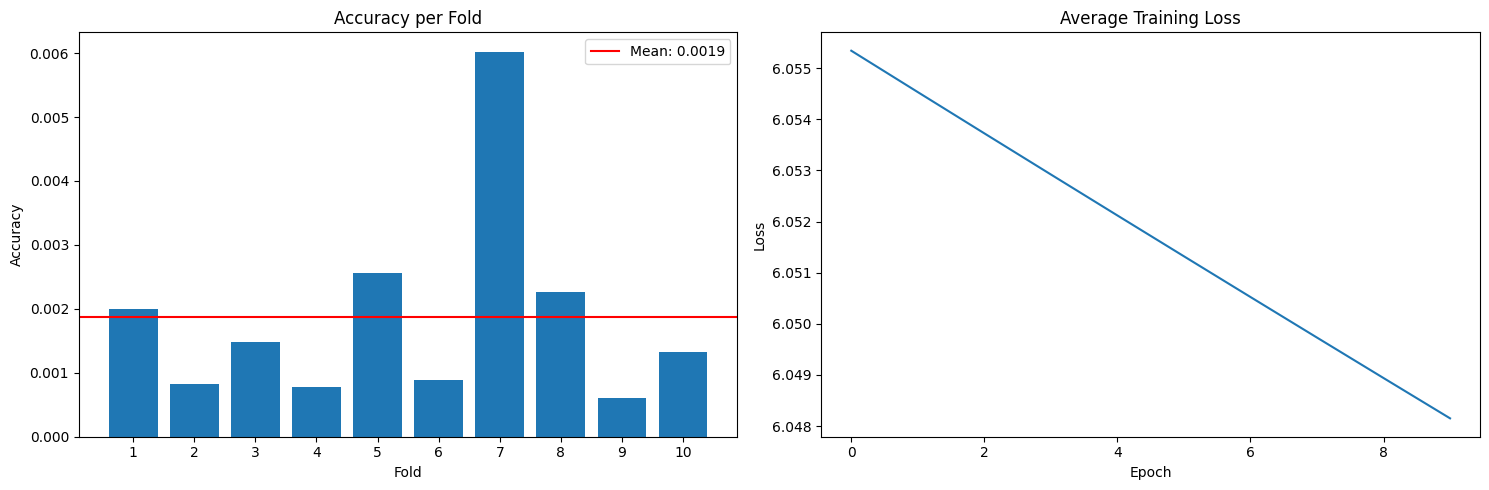


Running experiment with:
Hidden Layers: [64, 32]
Activation: tanh
Optimizer: batch_gradient_descent
Learning Rate: 0.01
Batch Size: 32

Using device: cuda
Processing fold 1


Loading test fold-1: 100%|██████████| 16992/16992 [00:02<00:00, 7686.51it/s]


Epoch 10/10, Loss: 5.9172
Fold 1 Accuracy: 0.0039 Avg Train Loss: 5.9447

Processing fold 2


Loading test fold-2: 100%|██████████| 16945/16945 [00:02<00:00, 7661.21it/s]


Epoch 10/10, Loss: 5.9289
Fold 2 Accuracy: 0.0028 Avg Train Loss: 5.9593

Processing fold 3


Loading test fold-3: 100%|██████████| 16913/16913 [00:02<00:00, 7649.89it/s]


Epoch 10/10, Loss: 5.9786
Fold 3 Accuracy: 0.0018 Avg Train Loss: 6.0433

Processing fold 4


Loading test fold-4: 100%|██████████| 16875/16875 [00:02<00:00, 7697.65it/s]


Epoch 10/10, Loss: 5.9085
Fold 4 Accuracy: 0.0026 Avg Train Loss: 5.9277

Processing fold 5


Loading test fold-5: 100%|██████████| 16838/16838 [00:02<00:00, 7703.53it/s]


Epoch 10/10, Loss: 5.9154
Fold 5 Accuracy: 0.0021 Avg Train Loss: 5.9467

Processing fold 6


Loading test fold-6: 100%|██████████| 16810/16810 [00:02<00:00, 7723.00it/s]


Epoch 10/10, Loss: 5.9385
Fold 6 Accuracy: 0.0108 Avg Train Loss: 5.9840

Processing fold 7


Loading test fold-7: 100%|██████████| 16769/16769 [00:02<00:00, 7544.76it/s]


Epoch 10/10, Loss: 5.9431
Fold 7 Accuracy: 0.0034 Avg Train Loss: 5.9712

Processing fold 8


Loading test fold-8: 100%|██████████| 16732/16732 [00:02<00:00, 7661.24it/s]


Epoch 10/10, Loss: 5.9176
Fold 8 Accuracy: 0.0022 Avg Train Loss: 5.9583

Processing fold 9


Loading test fold-9: 100%|██████████| 16698/16698 [00:02<00:00, 7606.74it/s]


Epoch 10/10, Loss: 5.8760
Fold 9 Accuracy: 0.0084 Avg Train Loss: 5.8954

Processing fold 10


Loading test fold-10: 100%|██████████| 16661/16661 [00:02<00:00, 7741.47it/s]


Epoch 10/10, Loss: 5.8787
Fold 10 Accuracy: 0.0154 Avg Train Loss: 5.9186



<Figure size 1500x500 with 0 Axes>

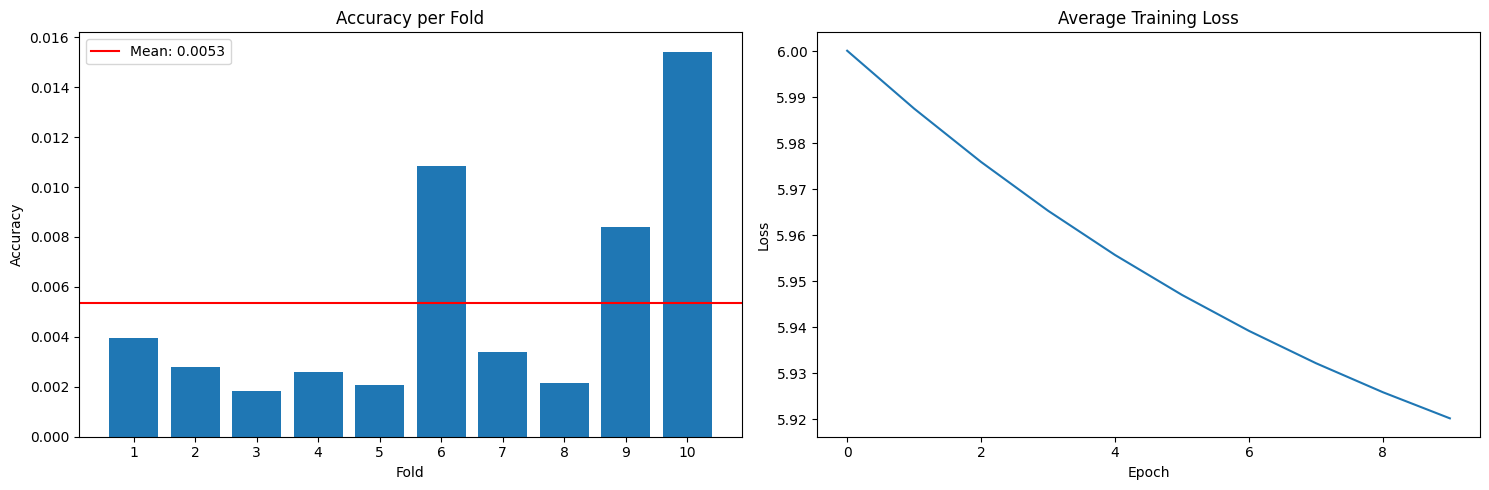


Running experiment with:
Hidden Layers: [64, 32]
Activation: relu
Optimizer: batch_gradient_descent
Learning Rate: 0.01
Batch Size: 32

Using device: cuda
Processing fold 1


Loading test fold-1: 100%|██████████| 16992/16992 [00:02<00:00, 7675.15it/s]


Epoch 10/10, Loss: 5.9733
Fold 1 Accuracy: 0.0022 Avg Train Loss: 6.0614

Processing fold 2


Loading test fold-2: 100%|██████████| 16945/16945 [00:02<00:00, 7685.20it/s]


Epoch 10/10, Loss: 5.9592
Fold 2 Accuracy: 0.0028 Avg Train Loss: 6.1638

Processing fold 3


Loading test fold-3: 100%|██████████| 16913/16913 [00:02<00:00, 7723.25it/s]


Epoch 10/10, Loss: 5.9256
Fold 3 Accuracy: 0.0039 Avg Train Loss: 5.9777

Processing fold 4


Loading test fold-4: 100%|██████████| 16875/16875 [00:02<00:00, 7676.91it/s]


Epoch 10/10, Loss: 5.9350
Fold 4 Accuracy: 0.0017 Avg Train Loss: 6.0644

Processing fold 5


Loading test fold-5: 100%|██████████| 16838/16838 [00:02<00:00, 7275.84it/s]


Epoch 10/10, Loss: 5.9574
Fold 5 Accuracy: 0.0036 Avg Train Loss: 6.0444

Processing fold 6


Loading test fold-6: 100%|██████████| 16810/16810 [00:02<00:00, 7714.17it/s]


Epoch 10/10, Loss: 5.9303
Fold 6 Accuracy: 0.0040 Avg Train Loss: 6.0604

Processing fold 7


Loading test fold-7: 100%|██████████| 16769/16769 [00:02<00:00, 7613.95it/s]


Epoch 10/10, Loss: 5.9564
Fold 7 Accuracy: 0.0047 Avg Train Loss: 6.0672

Processing fold 8


Loading test fold-8: 100%|██████████| 16732/16732 [00:02<00:00, 7748.27it/s]


Epoch 10/10, Loss: 5.9258
Fold 8 Accuracy: 0.0032 Avg Train Loss: 6.0561

Processing fold 9


Loading test fold-9: 100%|██████████| 16698/16698 [00:02<00:00, 7684.72it/s]


Epoch 10/10, Loss: 5.9428
Fold 9 Accuracy: 0.0031 Avg Train Loss: 6.0993

Processing fold 10


Loading test fold-10: 100%|██████████| 16661/16661 [00:02<00:00, 7667.81it/s]


Epoch 10/10, Loss: 5.9370
Fold 10 Accuracy: 0.0017 Avg Train Loss: 6.0738



<Figure size 1500x500 with 0 Axes>

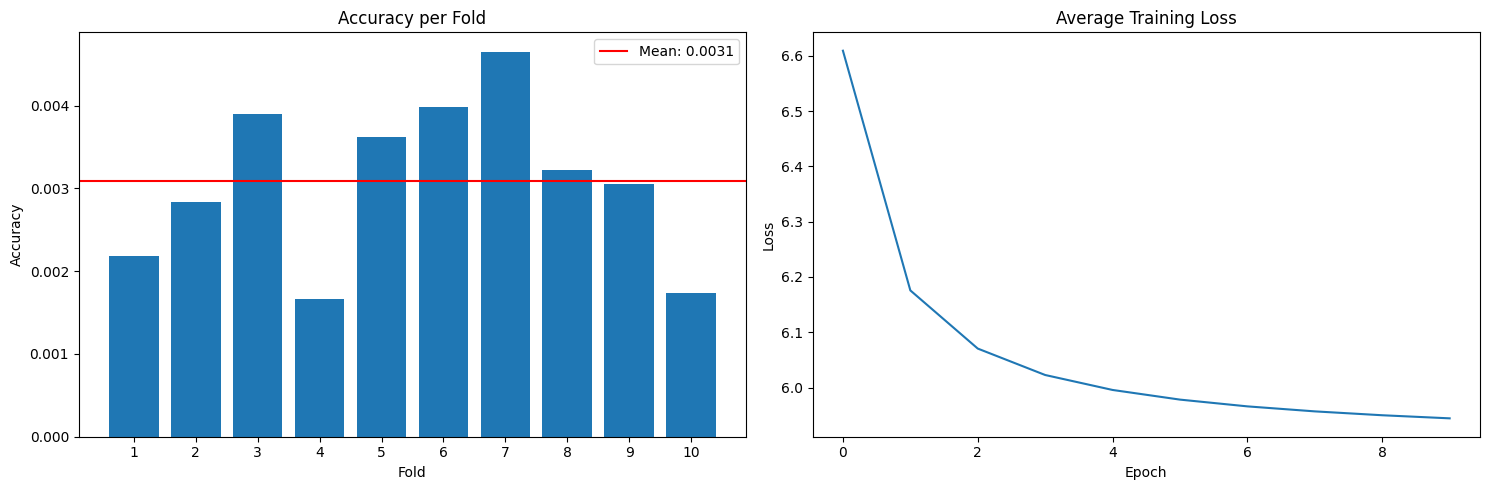


Running experiment with:
Hidden Layers: [64, 32]
Activation: sigmoid
Optimizer: mini_batch_gradient_descent
Learning Rate: 0.01
Batch Size: 32

Using device: cuda
Processing fold 1


Loading test fold-1: 100%|██████████| 16992/16992 [00:02<00:00, 7662.86it/s]


Epoch 10/10, Loss: 4.3604
Fold 1 Accuracy: 0.1796 Avg Train Loss: 4.9724

Processing fold 2


Loading test fold-2: 100%|██████████| 16945/16945 [00:02<00:00, 7298.64it/s]


Epoch 10/10, Loss: 4.3236
Fold 2 Accuracy: 0.1864 Avg Train Loss: 4.9743

Processing fold 3


Loading test fold-3: 100%|██████████| 16913/16913 [00:02<00:00, 7665.62it/s]


Epoch 10/10, Loss: 4.3744
Fold 3 Accuracy: 0.1744 Avg Train Loss: 4.9811

Processing fold 4


Loading test fold-4: 100%|██████████| 16875/16875 [00:02<00:00, 7599.55it/s]


Epoch 10/10, Loss: 4.3825
Fold 4 Accuracy: 0.1800 Avg Train Loss: 5.0164

Processing fold 5


Loading test fold-5: 100%|██████████| 16838/16838 [00:02<00:00, 7618.41it/s]


Epoch 10/10, Loss: 4.5091
Fold 5 Accuracy: 0.1389 Avg Train Loss: 5.0668

Processing fold 6


Loading test fold-6: 100%|██████████| 16810/16810 [00:02<00:00, 7619.80it/s]


Epoch 10/10, Loss: 4.3876
Fold 6 Accuracy: 0.1593 Avg Train Loss: 5.0189

Processing fold 7


Loading test fold-7: 100%|██████████| 16769/16769 [00:02<00:00, 7668.28it/s]


Epoch 10/10, Loss: 4.3168
Fold 7 Accuracy: 0.1833 Avg Train Loss: 4.9943

Processing fold 8


Loading test fold-8: 100%|██████████| 16732/16732 [00:02<00:00, 7743.24it/s]


Epoch 10/10, Loss: 4.4246
Fold 8 Accuracy: 0.1550 Avg Train Loss: 5.0292

Processing fold 9


Loading test fold-9: 100%|██████████| 16698/16698 [00:02<00:00, 7637.52it/s]


Epoch 10/10, Loss: 4.5039
Fold 9 Accuracy: 0.1543 Avg Train Loss: 5.0635

Processing fold 10


Loading test fold-10: 100%|██████████| 16661/16661 [00:02<00:00, 7267.41it/s]


Epoch 10/10, Loss: 4.5207
Fold 10 Accuracy: 0.1538 Avg Train Loss: 5.1013



<Figure size 1500x500 with 0 Axes>

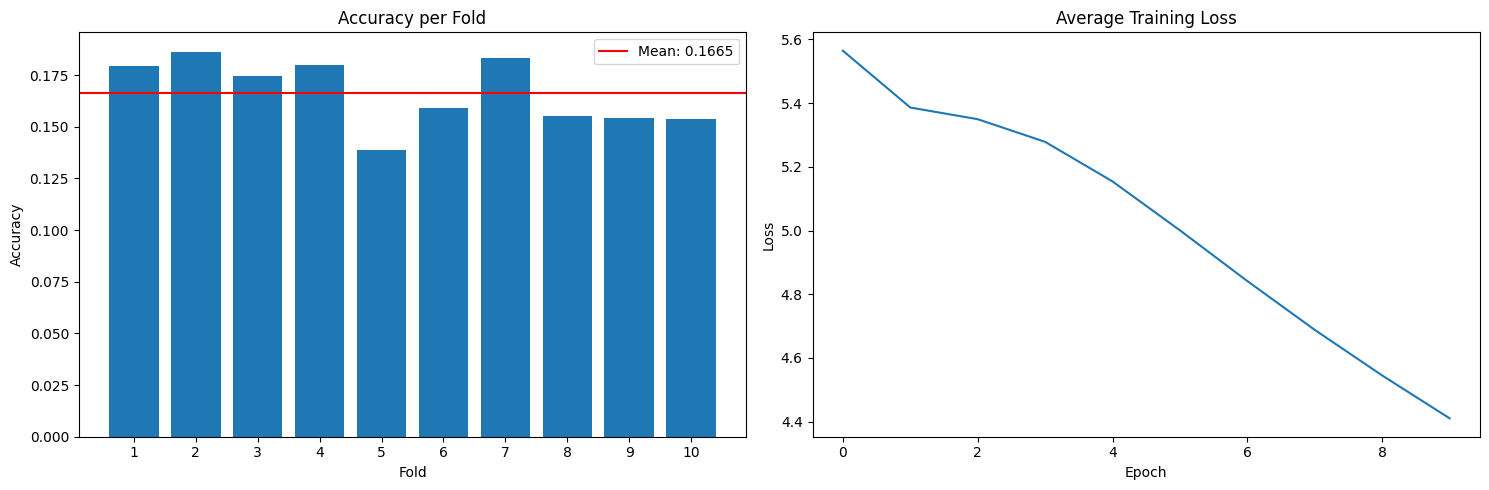


Running experiment with:
Hidden Layers: [64, 32]
Activation: tanh
Optimizer: mini_batch_gradient_descent
Learning Rate: 0.01
Batch Size: 32

Using device: cuda
Processing fold 1


Loading test fold-1: 100%|██████████| 16992/16992 [00:02<00:00, 7279.95it/s]


Epoch 10/10, Loss: 2.0803
Fold 1 Accuracy: 0.5479 Avg Train Loss: 2.8933

Processing fold 2


Loading test fold-2: 100%|██████████| 16945/16945 [00:02<00:00, 7291.91it/s]


Epoch 10/10, Loss: 2.1012
Fold 2 Accuracy: 0.5450 Avg Train Loss: 2.9331

Processing fold 3


Loading test fold-3: 100%|██████████| 16913/16913 [00:02<00:00, 7267.27it/s]


Epoch 10/10, Loss: 2.0759
Fold 3 Accuracy: 0.5446 Avg Train Loss: 2.9156

Processing fold 4


Loading test fold-4: 100%|██████████| 16875/16875 [00:02<00:00, 7536.84it/s]


Epoch 10/10, Loss: 2.0760
Fold 4 Accuracy: 0.5500 Avg Train Loss: 2.8992

Processing fold 5


Loading test fold-5: 100%|██████████| 16838/16838 [00:02<00:00, 7258.13it/s]


Epoch 10/10, Loss: 2.0763
Fold 5 Accuracy: 0.5390 Avg Train Loss: 2.9046

Processing fold 6


Loading test fold-6: 100%|██████████| 16810/16810 [00:02<00:00, 7283.43it/s]


Epoch 10/10, Loss: 2.0643
Fold 6 Accuracy: 0.5537 Avg Train Loss: 2.8624

Processing fold 7


Loading test fold-7: 100%|██████████| 16769/16769 [00:02<00:00, 7598.23it/s]


Epoch 10/10, Loss: 2.0729
Fold 7 Accuracy: 0.5434 Avg Train Loss: 2.9102

Processing fold 8


Loading test fold-8: 100%|██████████| 16732/16732 [00:02<00:00, 7642.94it/s]


Epoch 10/10, Loss: 2.0786
Fold 8 Accuracy: 0.5463 Avg Train Loss: 2.8751

Processing fold 9


Loading test fold-9: 100%|██████████| 16698/16698 [00:02<00:00, 7662.87it/s]


Epoch 10/10, Loss: 2.0714
Fold 9 Accuracy: 0.5548 Avg Train Loss: 2.9116

Processing fold 10


Loading test fold-10: 100%|██████████| 16661/16661 [00:02<00:00, 7205.99it/s]


Epoch 10/10, Loss: 2.0883
Fold 10 Accuracy: 0.5423 Avg Train Loss: 2.9103



<Figure size 1500x500 with 0 Axes>

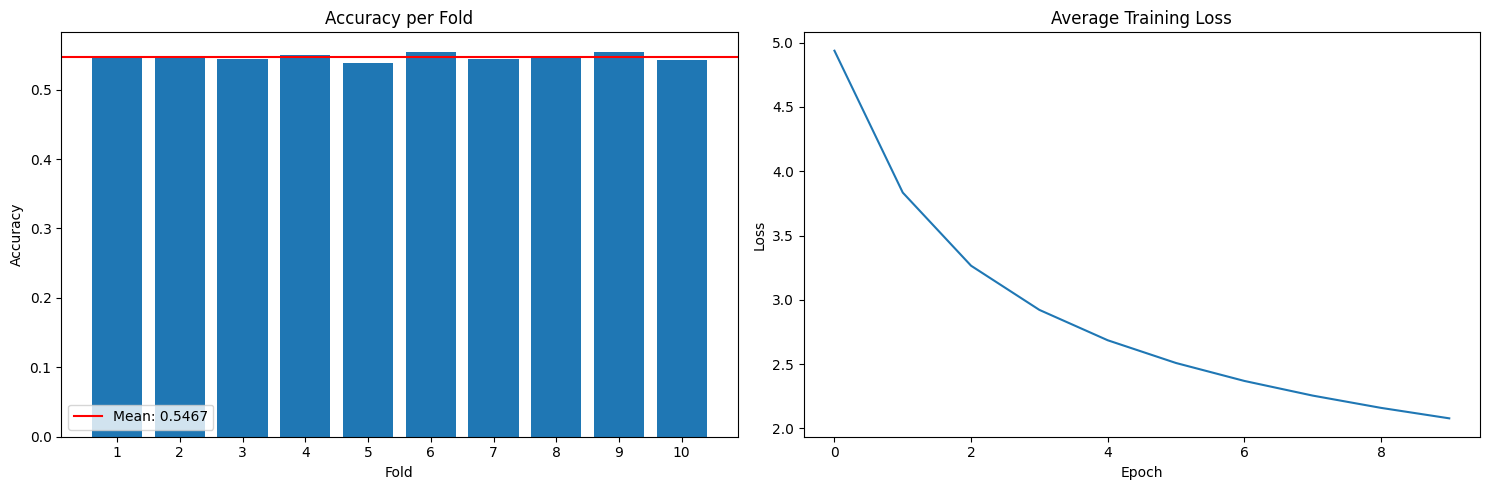


Running experiment with:
Hidden Layers: [64, 32]
Activation: relu
Optimizer: mini_batch_gradient_descent
Learning Rate: 0.01
Batch Size: 32

Using device: cuda
Processing fold 1


Loading test fold-1: 100%|██████████| 16992/16992 [00:02<00:00, 7216.34it/s]


Epoch 10/10, Loss: 1.6529
Fold 1 Accuracy: 0.5953 Avg Train Loss: 2.6226

Processing fold 2


Loading test fold-2: 100%|██████████| 16945/16945 [00:02<00:00, 7550.02it/s]


Epoch 10/10, Loss: 1.6021
Fold 2 Accuracy: 0.6233 Avg Train Loss: 2.4839

Processing fold 3


Loading test fold-3: 100%|██████████| 16913/16913 [00:02<00:00, 7583.81it/s]


Epoch 10/10, Loss: 1.6324
Fold 3 Accuracy: 0.6063 Avg Train Loss: 2.6025

Processing fold 4


Loading test fold-4: 100%|██████████| 16875/16875 [00:02<00:00, 7186.91it/s]


Epoch 10/10, Loss: 1.6142
Fold 4 Accuracy: 0.6013 Avg Train Loss: 2.5398

Processing fold 5


Loading test fold-5: 100%|██████████| 16838/16838 [00:02<00:00, 7214.00it/s]


Epoch 10/10, Loss: 1.6586
Fold 5 Accuracy: 0.4342 Avg Train Loss: 2.6463

Processing fold 6


Loading test fold-6: 100%|██████████| 16810/16810 [00:02<00:00, 7642.93it/s]


Epoch 10/10, Loss: 1.5805
Fold 6 Accuracy: 0.6267 Avg Train Loss: 2.5358

Processing fold 7


Loading test fold-7: 100%|██████████| 16769/16769 [00:02<00:00, 7600.11it/s]


Epoch 10/10, Loss: 1.6370
Fold 7 Accuracy: 0.5824 Avg Train Loss: 2.6183

Processing fold 8


Loading test fold-8: 100%|██████████| 16732/16732 [00:02<00:00, 7663.20it/s]


Epoch 10/10, Loss: 1.5540
Fold 8 Accuracy: 0.5992 Avg Train Loss: 2.5178

Processing fold 9


Loading test fold-9: 100%|██████████| 16698/16698 [00:02<00:00, 7640.71it/s]


Epoch 10/10, Loss: 1.6097
Fold 9 Accuracy: 0.6089 Avg Train Loss: 2.5380

Processing fold 10


Loading test fold-10: 100%|██████████| 16661/16661 [00:02<00:00, 7610.79it/s]


Epoch 10/10, Loss: 1.5781
Fold 10 Accuracy: 0.6167 Avg Train Loss: 2.5611



<Figure size 1500x500 with 0 Axes>

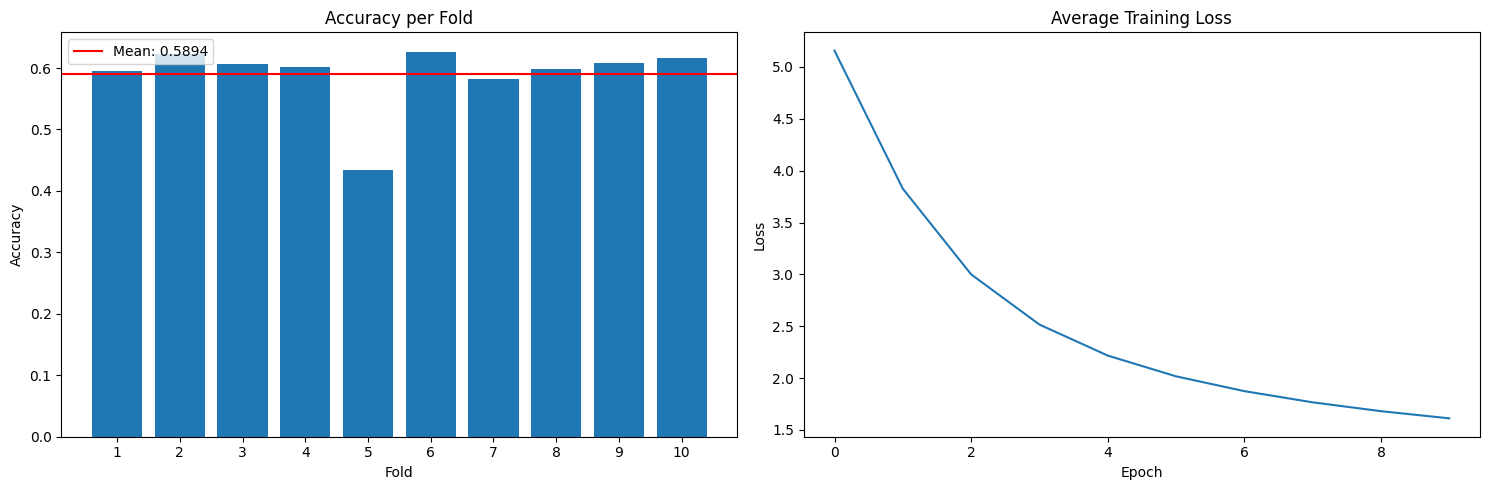



RESULTS SUMMARY (ORDERED BY MEAN ACCURACY)
Rank  Hidden Layers       ActivationOptimizer      Learning Rate  Batch Size     Mean Accuracy  Std Dev   
----------------------------------------------------------------------------------------------------
1     [64, 32]            sigmoid   sgd            0.01           1              0.6238±0.0064
2     [64, 32]            relu      mini_batch_gradient_descent0.01           32             0.5894±0.0533
3     [64, 32]            tanh      mini_batch_gradient_descent0.01           32             0.5467±0.0047
4     [64, 32]            tanh      sgd            0.01           1              0.4803±0.0162
5     [64, 32]            relu      sgd            0.01           1              0.2970±0.0369
6     [64, 32]            sigmoid   mini_batch_gradient_descent0.01           32             0.1665±0.0153
7     [64, 32]            tanh      batch_gradient_descent0.01           32             0.0053±0.0044
8     [64, 32]            relu      bat

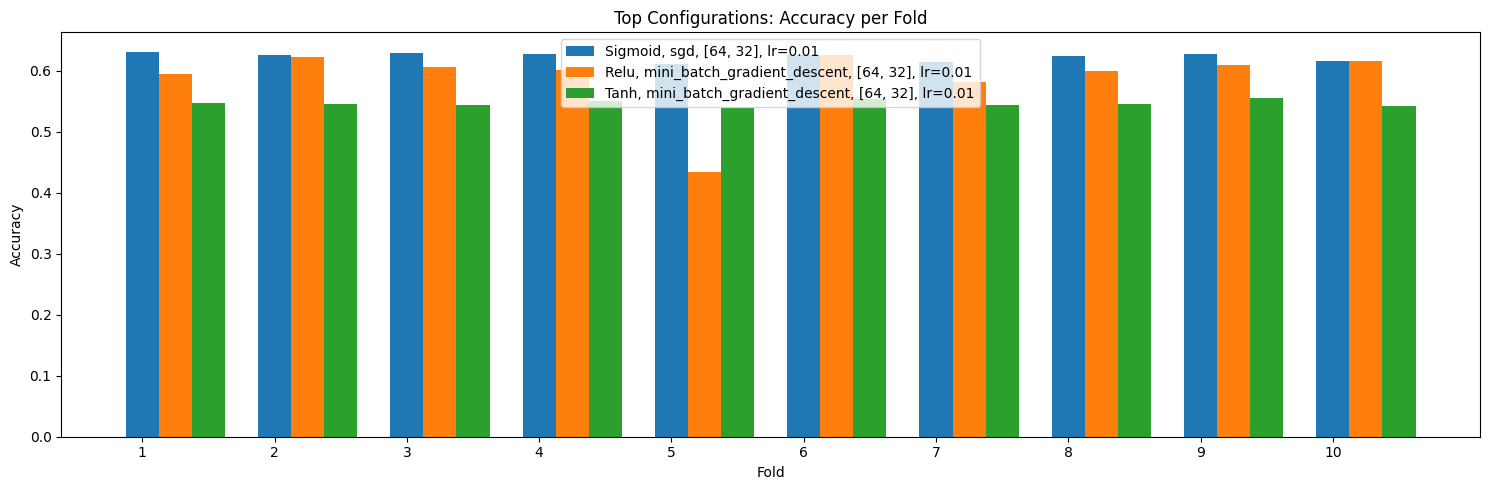


Best configuration: Sigmoid, sgd, layers=[64, 32], lr=0.01
Mean accuracy: 0.6238±0.0064


In [ ]:
class MathSymbolDataset(Dataset):
    def __init__(self, dataframe, image_dir, transform=None):
        self.dataframe = dataframe
        self.image_dir = image_dir
        self.transform = transform
        
        unique_symbols = sorted(self.dataframe['symbol_id'].unique())
        self.symbol_to_idx = {symbol: idx for idx, symbol in enumerate(unique_symbols)}
        self.idx_to_symbol = {idx: symbol for symbol, idx in self.symbol_to_idx.items()}
        self.idx_to_latex = {idx: self.dataframe[self.dataframe['symbol_id'] == symbol]['latex'].iloc[0] 
                            for symbol, idx in self.symbol_to_idx.items()}
        
        self.num_classes = len(unique_symbols)
    
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.dataframe.iloc[idx]['path'].replace('../../images/', ''))
        image = Image.open(img_path).convert('L')  # Convert to grayscale
        
        symbol_id = self.dataframe.iloc[idx]['symbol_id']
        label = self.symbol_to_idx[symbol_id]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

def load_and_preprocess_data(base_dir, fold_num=None):
    image_dir = os.path.join(base_dir, "images")
    task_dir = os.path.join(base_dir, "classification-task")
    
    # Determine which folds to process
    if fold_num is not None:
        folds = [f"fold-{fold_num}"]
    else:
        folds = [f"fold-{i}" for i in range(1, 11)]
    
    transform = transforms.Compose([
        transforms.Resize((32, 32)),  # Resize images to a standard size
        transforms.ToTensor(),         # Convert to tensor
        transforms.Normalize((0.5,), (0.5,))  # Normalize grayscale images
    ])
    train_datasets = []
    test_datasets = []

    for fold in folds:
        fold_path = os.path.join(task_dir, fold)
        
        train_df = pd.read_csv(os.path.join(fold_path, 'train.csv'))
        test_df = pd.read_csv(os.path.join(fold_path, 'test.csv'))
        
        train_dataset = MathSymbolDataset(train_df, base_dir, transform)
        test_dataset = MathSymbolDataset(test_df, base_dir, transform)
        
        train_datasets.append(train_dataset)
        test_datasets.append(test_dataset)
    
    # Use the mapping from the first dataset
    symbol_to_idx = train_datasets[0].symbol_to_idx
    idx_to_symbol = train_datasets[0].idx_to_symbol
    idx_to_latex = train_datasets[0].idx_to_latex
    num_classes = train_datasets[0].num_classes
    
    # Extract features and labels
    X_train, y_train = extract_features_and_labels(train_datasets, transform)
    X_test, y_test = extract_features_and_labels(test_datasets, transform)
    
    # Convert to tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.long)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.long)
    
    symbol_mapping = {
        'symbol_to_idx': symbol_to_idx,
        'idx_to_symbol': idx_to_symbol,
        'idx_to_latex': idx_to_latex,
        'num_classes': num_classes
    }
    
    return X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor, symbol_mapping

def extract_features_and_labels(datasets, transform):

    features = []
    labels = []
    
    for dataset in datasets:
        for i in range(len(dataset)):
            image, label = dataset[i]
            # Flatten the image tensor
            features.append(image.flatten().numpy())
            labels.append(label)
    
    return np.array(features), np.array(labels)


base_dir = "./"  # Update this to your actual base directory

X_train, y_train, X_test, y_test, symbol_mapping = load_and_preprocess_data(base_dir)


# Now call the hyperparameter search function
results = hyperparam_search(X_train, y_train)

# Plot the top configurations
top_n = min(3, len(results))

plt.figure(figsize=(15, 5))
plt.title(f"Comparison of Top {top_n} Configurations")

for i in range(top_n):
    result = results[i]
    plt.bar(
        [x + (i * 0.25) for x in range(1, 6)],  # Assuming 5-fold CV
        result['accuracies'],
        width=0.25,
        label=f"{result['activation'].capitalize()}, {result['optimizer']}, {result['hidden_layers']}, lr={result['learning_rate']}"
    )

plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.title('Top Configurations: Accuracy per Fold')
plt.xticks(range(1, 6))
plt.legend()
plt.tight_layout()
plt.show()

best_model_config = results[0]
print(f"\nBest configuration: {best_model_config['activation'].capitalize()}, {best_model_config['optimizer']}, layers={best_model_config['hidden_layers']}, lr={best_model_config['learning_rate']}")
print(f"Mean accuracy: {best_model_config['mean_accuracy']:.4f}±{best_model_config['std_accuracy']:.4f}")

### **Report on Model Performance**  

#### **Mean Accuracy**  
Mean accuracy represents the model's expected performance on unseen data. A higher mean accuracy indicates better predictive capability. In handwritten symbol classification, achieving high accuracy is crucial for ensuring reliable recognition and digital archiving.  

#### **Standard Deviation**  
Standard deviation measures how much the accuracy varies across different folds. A lower standard deviation suggests the model performs consistently across various data subsets, while a higher value indicates sensitivity to data splits, which can signal potential overfitting.  

#### **Interpreting Standard Deviation**  
- **Low Standard Deviation**: The model generalizes well across different data distributions, increasing confidence in its predictions on new inputs.  
- **High Standard Deviation**: Performance fluctuates significantly, making it less reliable. This inconsistency can suggest overfitting, where the model learns patterns specific to certain training data but struggles with new examples.  

#### **Choosing Between Models**  
If given two models—one with **higher mean accuracy but high variance** and another with **slightly lower accuracy but low variance**, the second model is preferable. Despite its marginally lower accuracy, its stability ensures better real-world reliability. The first model’s variability may indicate overfitting, making its performance unpredictable on unseen data.
